In [1]:
!pwd

/home/giakhang/dev/SCFlow


In [55]:
from mmengine import Config
from registry import MODELS, DATASETS, HOOKS, METRICS
from mmengine.runner import Runner
from mmengine.optim import DefaultOptimWrapperConstructor
from torch.nn.parallel import DataParallel as MMDataParallel

import matplotlib.pyplot as plt

import trimesh
from tools.visualize import draw_detections

import numpy as np
import cv2


In [68]:
#cfg = Config.fromfile("./configs/refine_models/scflow_lumi_piano_syn.py")
#cfg = Config.fromfile("./configs/refine_models/scflow_lumi_piano_real.py")
cfg = Config.fromfile("./configs/refine_models/scflow_lumi_piano_real_mix_syn.py")

model = MODELS.build(cfg.model)
#metrics = METRICS.build(cfg.val_evaluator)

dataset = DATASETS.build(cfg.train_dataloader.dataset)

result_dict = dataset[50]

100%|██████████| 1362/1362 [00:00<00:00, 13209.12it/s]


In [69]:
cad_path = "./data/syn_lumi_piano_dataset/models_1080_mm/LUMI.obj"
mesh = trimesh.load_mesh(cad_path)
mesh = mesh.sample(1024).astype(np.float32)

In [70]:
img = result_dict['img'].data
img = img.permute(0, 2, 3, 1)[0].to('cpu').numpy()

# Train set

In [71]:
img_path = result_dict['img_metas'].data['img_path']
rot = result_dict['img_metas'].data['ori_gt_rotations'][0]
trans = result_dict['img_metas'].data['ori_gt_translations'][0]
K = result_dict['img_metas'].data['ori_k'][0]

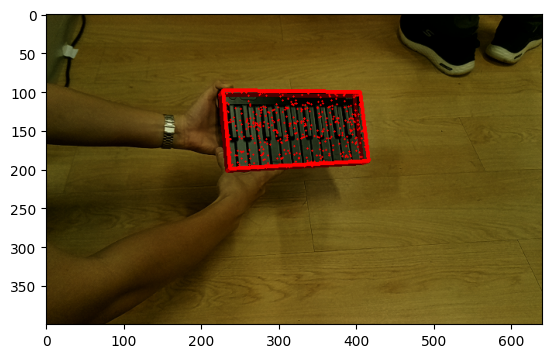

In [72]:
img = cv2.imread(img_path)[..., ::-1]

img = draw_detections(img, rot[None, ...], trans[None, ...], mesh, K[None, ...])

plt.imshow(img)

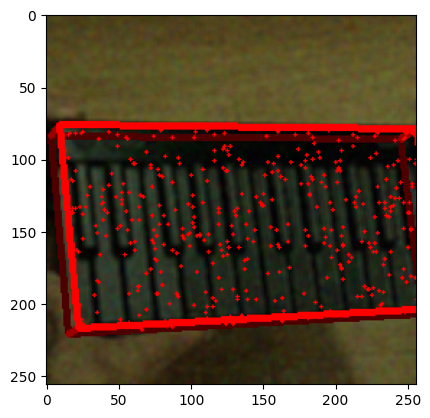

In [73]:
img = result_dict['img'].data[0].permute(1, 2, 0).to('cpu').numpy()
img = (img * 255).astype(np.uint8)  
rot = result_dict['annots']['gt_rotations'].data[0].to('cpu').numpy()
trans = result_dict['annots']['gt_translations'].data[0].to('cpu').numpy()
k = result_dict['annots']['k'].data[0].to('cpu').numpy()

img = draw_detections(img, rot[None, ...], trans[None, ...], mesh, k[None, ...])

plt.imshow(img)

# Test set

In [22]:
test_dataset = DATASETS.build(cfg.test_dataloader.dataset)

test_result_dict = test_dataset[0]

100%|██████████| 27/27 [00:00<00:00, 83147.00it/s]


In [23]:
img_path = test_result_dict['img_metas'].data['img_path']

rot = test_result_dict['annots']['gt_rotations'].data[0].to('cpu').numpy()
trans = test_result_dict['annots']['gt_translations'].data[0].to('cpu').numpy()
ori_k = test_result_dict['annots']['ori_k'].data.to('cpu').numpy()

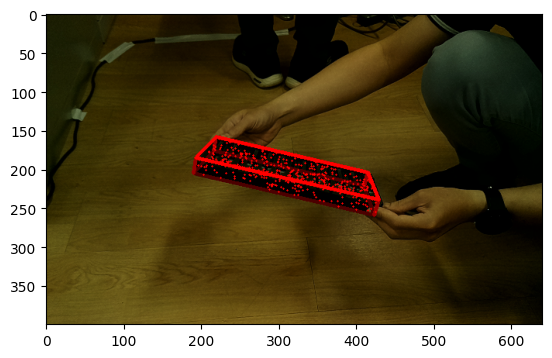

In [24]:
img = cv2.imread(img_path)[..., ::-1]

img = draw_detections(img, rot[None, ...], trans[None, ...], mesh, ori_k[None, ...])

plt.imshow(img)

In [25]:
cropped_img = test_result_dict['img'].data[0].permute(1, 2, 0).to('cpu').numpy()
trans_mat = test_result_dict['annots']['transform_matrix'].data[0].to('cpu').numpy()

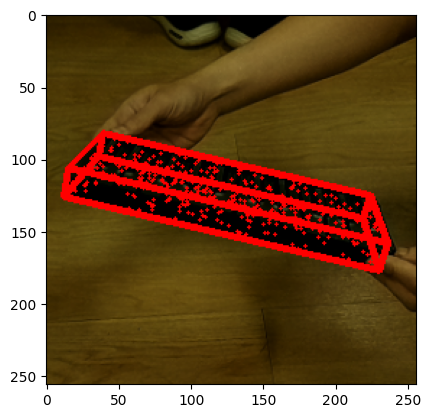

In [26]:
img = draw_detections(
    cropped_img, 
    rot[None, ...], 
    trans[None, ...], 
    mesh, 
    (trans_mat @ ori_k)[None, ...]
)

plt.imshow(img)